In [1]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

### Setup the notebook.

In [2]:
import h5py
import math
testNames=["dimerization_reversible_1",
           "dimerization_reversible_2",
           "dimerization_reversible_3"]
test_names_bash_list=" ".join(testNames)
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [3]:
%%bash
rm -rf tmp && mkdir tmp

In [4]:
%%bash -s "$test_names_bash_list"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    rm -f ${outputFilename}* && lm_sbml_import ${outputFilename} ${testName}.sbml > ${outputFilename}.import.log
    lm_setp ${outputFilename} writeInterval=1e-3 maxTime=1e0 > /dev/null
done;
echo "Finished."

Finished.


### Echo the commands to execute the simulations.

In [5]:
%%bash -s "$test_names_bash_list"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    echo lmes -r 1-1000 -f ${outputFilename} \> ${outputFilename}.simulate.log
done;

lmes -r 1-1000 -f tmp/dimerization_reversible_1.lm > tmp/dimerization_reversible_1.lm.simulate.log
lmes -r 1-1000 -f tmp/dimerization_reversible_2.lm > tmp/dimerization_reversible_2.lm.simulate.log
lmes -r 1-1000 -f tmp/dimerization_reversible_3.lm > tmp/dimerization_reversible_3.lm.simulate.log


### Execute the simulations.

In [6]:
%%bash -s "$test_names_bash_list"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    lmes -r 1-1000 -f ${outputFilename} -sl lm::cme::GillespieDSolver > ${outputFilename}.simulate.log
done;
echo "Finished."

Finished.


### Spot check some simulations.

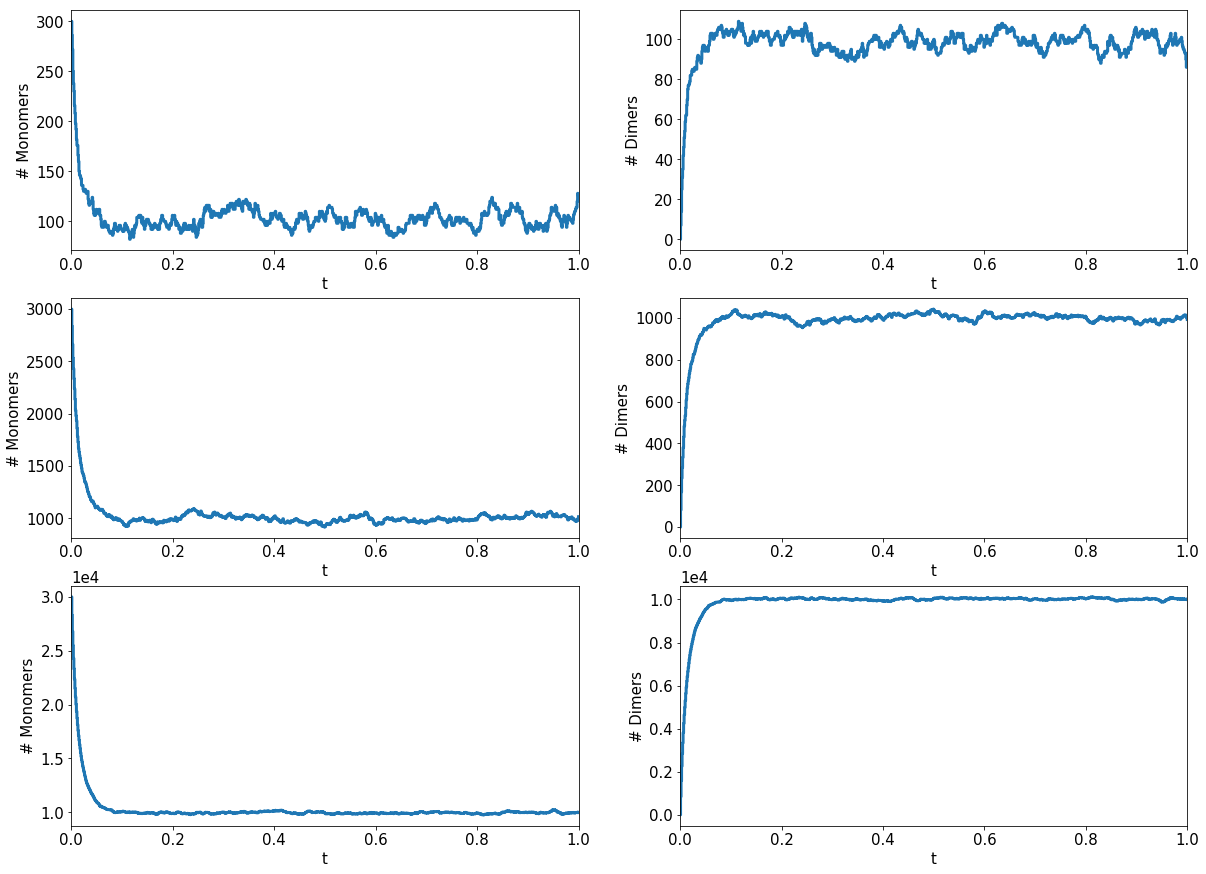

In [7]:
# Plot the time series for a single replicate.
for i,testName in enumerate(testNames):
    testOutputFilename="tmp/%s.lm"%(testName)
    fp = h5py.File(testOutputFilename, "r")
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5*len(testNames))})
    for replicate in (1,):
        counts=np.array(fp["/Simulations/%07d/SpeciesCounts"%replicate], dtype=double)
        times=np.array(fp["/Simulations/%07d/SpeciesCountTimes"%replicate], dtype=double)
        plt.subplot(len(testNames),2,i*2+1)
        step(times,counts[:,0], **stepStyles)
        xlabel('t'); xlim([0,1e0]); ylabel('# Monomers'); title("")
        plt.subplot(len(testNames),2,i*2+2)
        step(times,counts[:,1], **stepStyles)
        xlabel('t'); xlim([0,1e0]); ylabel('# Dimers'); title("")
    fp.close()
pass

### Define the tests.

In [8]:
def test_dimerization_reversible_1(testOutputFilename):
    test_dimerization_reversible(testOutputFilename, 100.0, 1e-2)
def test_dimerization_reversible_2(testOutputFilename):
    test_dimerization_reversible(testOutputFilename, 1000.0, 1e-3)
def test_dimerization_reversible_3(testOutputFilename):
    test_dimerization_reversible(testOutputFilename, 10000.0, 1e-3)
    
def test_dimerization_reversible(testOutputFilename, exceptedValue, allowedDeviation):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    for replicate in replicates:
        if times is None:
            times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        if mSim is None:
            k += 1
            mSim = counts
            vSim = np.zeros(counts.shape, dtype=double)
        else:
            k += 1
            mSim = mSim + (counts-mSim)/k
            vSim = vSim + (counts-mSim)*(counts-mSim)
    vSim /= float((k-1))
    value = np.mean(mSim[-100:-1,0])

    plt.subplot(len(testNames),2,i*2+1)
    plt.plot(times,mSim[:,0], **plotStyles)
    plt.plot(times,mSim[:,1], **plotStyles)
    yscale('linear'); xlabel('t'); ylabel('E{X(t)}'); title("%s, $\mu$=%0.2f"%(testName,value))
    plt.subplot(len(testNames),2,i*2+2)
    plt.plot(times,vSim[:,0], **plotStyles)
    plt.plot(times,vSim[:,1], **plotStyles)
    yscale('log'); xlabel('t'); ylabel('Var{X(t)}')
    fp.close()

    if not isclose(value,exceptedValue,allowedDeviation): raise Exception("incorrect value",value)

### Run the tests.

[dimerization_reversible_1]                                  : passed.


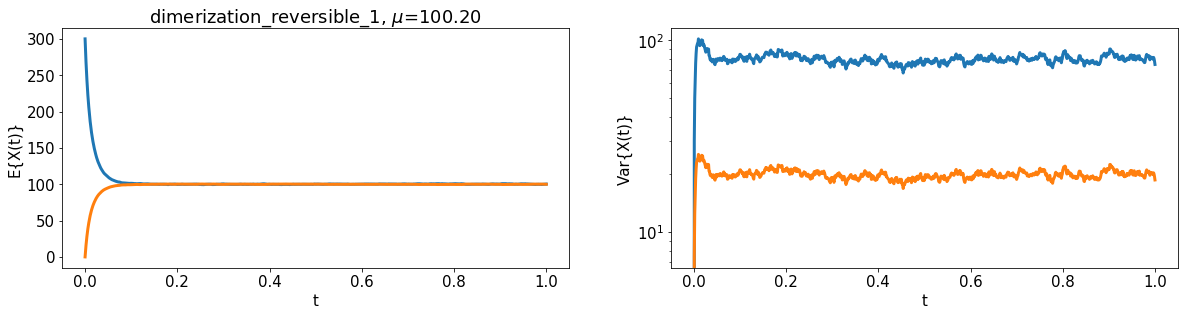

[dimerization_reversible_2]                                  : passed.


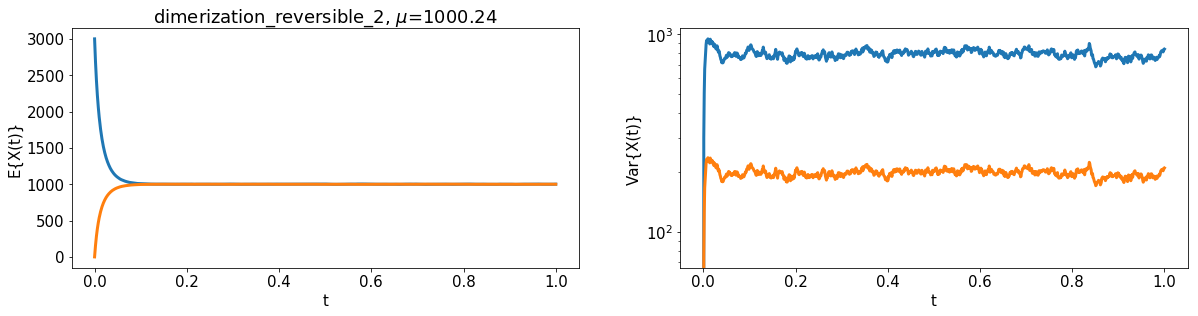

[dimerization_reversible_3]                                  : passed.


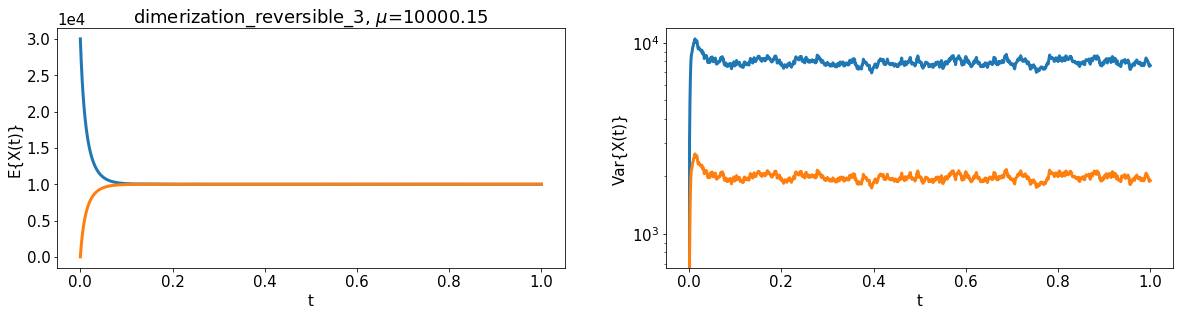

In [9]:
testMethods = {"dimerization_reversible_1": test_dimerization_reversible_1,
              "dimerization_reversible_2": test_dimerization_reversible_2,
              "dimerization_reversible_3": test_dimerization_reversible_3}
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5*len(testNames))})
for i,testName in enumerate(testNames):
    try:
        testOutputFilename="tmp/%s.lm"%(testName)
        testMethods[testName](testOutputFilename)
    except Exception as e:
        print "%-60s : FAILED with:"%("["+testName+"]"),e
    except:
        print "%-60s : FAILED with: Unknown exception"%("["+testName+"]")
    else:
        print "%-60s : passed."%("["+testName+"]")
    plt.show()
pass

In [10]:
%%bash
rm -rf tmp